In [1]:
from hyperopt import Trials
import joblib
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
import cv2

import common.loss_utils as loss_utils


In [24]:
t = joblib.load('trials_1flow_improved.joblib')

In [26]:
t

In [8]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [9]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [10]:
def check_times(tstart, tend):
    # check_times(times[0], times[35])
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

In [11]:

class DataFetcher:
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
#         rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
#         rand_y = self.generator.randint(0, input_slice.shape[1] - 128)
        rand_x = (input_slice.shape[2] - 128) // 2
        rand_y = (input_slice.shape[1] - 128) // 2

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = DataFetcher(times, data)

In [12]:
x, y = ds[0]

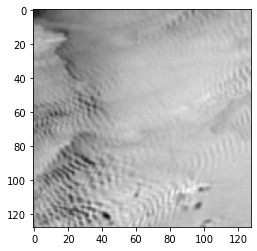

In [13]:
plt.imshow(x[0], cmap='gray')

In [14]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return res

def get_mssim(y, x):
    if len(y.shape) == 2:
        # we need to specify a number of channels. This sets it to 1 and calls the function again
        return get_mssim(np.expand_dims(y, 0), np.expand_dims(x, 0))
    if len(y.shape) == 4:
        y = y.reshape(-1, y.shape[2], y.shape[3])
        x = x.reshape(-1, x.shape[2], x.shape[3])
    assert len(y.shape) == 3
    mssim_loss = loss_utils.MS_SSIMLoss(data_range=1023, channels=y.shape[0])
    yd = np.expand_dims(y, 0) # /255 * (MAX - MIN) + MIN
    xd = np.expand_dims(x, 0) # /255 * (MAX - MIN) + MIN
    return 1.0 - mssim_loss(
        torch.Tensor(yd),
        torch.Tensor(xd),
    ).item()

In [17]:
np.random.seed(7)
indices = np.arange(len(ds))
np.random.shuffle(indices)

In [15]:
LOOKS = 500


In [29]:
forecast = 20
params = {
    'pyr_scale': 0.1900843979,
    'levels': 4,
    'winsize': 3,
    'iterations': 1,
    'poly_n': 7,
    'poly_sigma': 1.286678996,
    
}


In [139]:
optical_flow_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    flow = cv2.calcOpticalFlowFarneback(
        prev=x[-2],
        next=x[-1],
        flow=None,
        **params,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
    )
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(forecast):
        cur = warp_flow(cur, flow)
        cur = cv2.blur(cur, (3, 3))
        preds[j] = cur[32:96,32:96]
    remaining = 24 - forecast
    # just propogate the final prediction
    if remaining > 0:
        preds[forecast:] = cur[32:96,32:96]
    score = get_mssim(preds, y)
    optical_flow_scores.append(score)


100%|██████████| 500/500 [00:04<00:00, 104.44it/s]


In [140]:
np.mean(optical_flow_scores)

0.6943059215545654

In [129]:
np.mean(optical_flow_scores)

0.6943059215545654

In [32]:
np.mean(optical_flow_scores)

0.6740348678827286

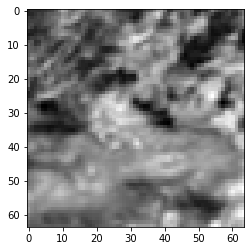

In [130]:
plt.imshow(x[-1,32:96,32:96], cmap='gray')

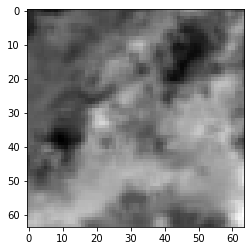

In [143]:
plt.imshow(preds[2], cmap='gray')

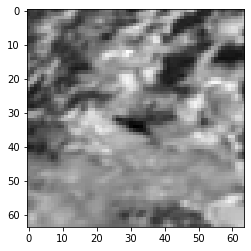

In [144]:
plt.imshow(y[2], cmap='gray')

In [ ]:
!ls

In [51]:
sec = preds[0,30:45,30:40]

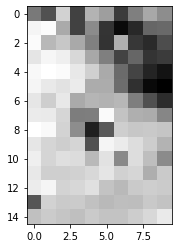

In [132]:
plt.imshow(sec, cmap='gray')

In [78]:
thresh = 400 # 0.701 -> 0.707

preds_new = preds[0].copy()
for i in range(1, preds_new.shape[1] - 1):
    for j in range(1, preds_new.shape[0] - 1):
        # check top-left
        if abs(preds_new[i,j] - preds_new[i-1,j]) > thresh or abs(preds_new[i,j] - preds_new[i,j-1]) > thresh:
            preds_new[i,j] = (preds_new[i-1,j] + preds_new[i,j-1])/2


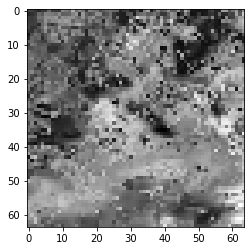

In [58]:
plt.imshow(preds[0], cmap='gray')

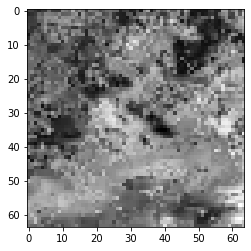

In [66]:
plt.imshow(preds_new, cmap='gray')

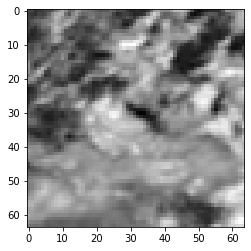

In [36]:
plt.imshow(y[0], cmap='gray')

In [92]:
preds_new = preds[0].copy()
preds_new[30:40,0:10] = y[0,30:40,0:10]

In [86]:
y.shape

(24, 64, 64)

In [93]:
preds_new.shape

(64, 64)

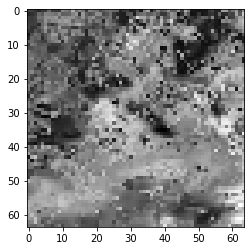

In [101]:
plt.imshow(preds[0], cmap='gray')

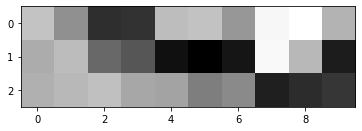

In [102]:
plt.imshow(preds[0,30:33,:10], cmap='gray')

In [99]:
for item in flow[30:40,:10]:
    print(item)

[[  1.2875931  -6.4904323]
 [ -2.895332    4.308706 ]
 [ -3.5881138   2.7576616]
 [  1.1825377   2.4675152]
 [ -2.712211    2.6602283]
 [ -6.1211624   5.358745 ]
 [-15.221754   14.16392  ]
 [  2.081748   -2.8268049]
 [ -1.9673427   1.2485529]
 [ -1.1253358   3.5081596]]
[[-0.7228685   2.059942  ]
 [-1.1835864   1.7169164 ]
 [-2.9101253   1.6127986 ]
 [-0.16202435  1.2255999 ]
 [-1.984951    1.719929  ]
 [-3.7374082   2.6998742 ]
 [-6.057446    4.194358  ]
 [-9.22985     5.6252775 ]
 [-0.02406256 -0.38006437]
 [-2.299043   10.296873  ]]
[[ -0.38119122   1.5444477 ]
 [ -0.83965796   1.4135602 ]
 [ -3.4798822    1.6737765 ]
 [ -0.18774967   1.1313592 ]
 [ -1.5609617    1.5935209 ]
 [ -2.9627395    2.2814548 ]
 [ -5.1261725    3.031802  ]
 [-13.292267     0.45801136]
 [  0.3961642    5.669805  ]
 [ -0.75766367   0.20728251]]
[[ 8.0607953e-03  1.6482861e+00]
 [-3.1326661e-01  1.3271576e+00]
 [-3.4000399e+00  1.6634220e+00]
 [ 1.5188825e-01  5.8812648e-01]
 [-1.0250368e+00  1.0520474e+00]
 [

In [59]:
get_mssim(x[-1:,32:96,32:96], y[:1])

0.6635304093360901

In [60]:
get_mssim(preds[:1], y[:1])

0.7018651366233826

In [95]:
preds_new = np.expand_dims(preds_new, axis=0)
get_mssim(preds_new, y[:1])

0.7158536911010742

In [122]:
o = np.zeros(preds.shape)
for i in range(preds.shape[0]):
    o[i] = cv2.blur(preds[i], (3, 3))

In [127]:
# test = np.expand_dims(test, axis=0)
get_mssim(o[1:2], y[1:2])

0.5489885210990906